In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from iminuit import Minuit
# from sklearn.metrics import f1_score

In [42]:
data = np.load("../data/energy_pdfs.npz")
pdf_A = data['pdf_A']
pdf_B  = data['pdf_B']
pdf_C = data['pdf_C']
pdf_ovbb = data['pdf_ovbb']
bin_edges = data['bin_edges']
bin_centers = data['bin_centers']
counts_Target = data['counts_Target']

In [55]:
from iminuit import Minuit
import numpy as np
import matplotlib.pyplot as plt

def fit_detector_target(counts_Target, pdf_A, pdf_B, pdf_C, pdf_ovbb, bin_edges):
    """
    Fit DetectorTarget histogram with template PDFs and show uncertainties.
    """
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Model chi2 function
    def chi2(theta_A, theta_B, theta_C, theta_ovbb):
        model = (theta_A * pdf_A + theta_B * pdf_B + theta_C * pdf_C + theta_ovbb * pdf_ovbb)
        return np.sum((counts_Target - model)**2 / (model + 1e-6))  # avoid div0

    def nll(theta_A, theta_B, theta_C, theta_ovbb):
        mu = (theta_A * pdf_A +
              theta_B * pdf_B +
              theta_C * pdf_C +
              theta_ovbb * pdf_ovbb)

        # Avoid log(0)
        mu = np.clip(mu, 1e-12, None)

        # Poisson negative log-likelihood (ignoring ln(n!))
        return 2 * np.sum(mu - counts_Target * np.log(mu))

    # Initial guess
    m = Minuit(nll, theta_A=500, theta_B=300, theta_C=100, theta_ovbb=10)
    m.errordef = 1  # chi2
    m.limits = [(0, None), (0, None), (0, None), (0, None)]
    m.migrad()

    # Extract fit values and errors
    theta_fit = m.values
    theta_err = m.errors

    print("Fitted θ values ± 1σ:")
    for i, name in enumerate(['theta_A', 'theta_B', 'theta_C', 'theta_ovbb']):
        print(f"{name} = {theta_fit[i]:.2f} ± {theta_err[i]:.2f}")

    # Model counts
    model_counts = (theta_fit['theta_A']*pdf_A +
                    theta_fit['theta_B']*pdf_B +
                    theta_fit['theta_C']*pdf_C +
                    theta_fit['theta_ovbb']*pdf_ovbb)

    # Setup figure with ratio subplot
    fig, (ax_main, ax_ratio) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios':[3,1]}, sharex=True)

    # Main histogram
    ax_main.bar(bin_centers, counts_Target, width=bin_width, color='gray', alpha=0.6, label='Data')
    ax_main.step(bin_centers, model_counts, color='red', where='mid', label='Fit')
    ax_main.set_ylabel("Counts / bin")
    ax_main.set_title("DetectorTarget Fit with Template PDFs")
    ax_main.legend()
    ax_main.grid(alpha=0.3)

    # Ratio plot
    mask = counts_Target > 2  # ignore bins with less than 2 counts
    ratio = model_counts[mask] / counts_Target[mask]
    ax_ratio.step(bin_centers[mask], ratio, color='blue', where='mid')
    ax_ratio.axhline(1, color='black', linestyle='--')
    ax_ratio.set_xlabel("Energy (keV)")
    ax_ratio.set_ylabel("Fit / Data")
    ax_ratio.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return theta_fit, theta_err


Fitted θ values ± 1σ:
theta_A = 172.56 ± 58.26
theta_B = 379.37 ± 55.84
theta_C = 213.36 ± 57.88
theta_ovbb = 7.49 ± 2.78


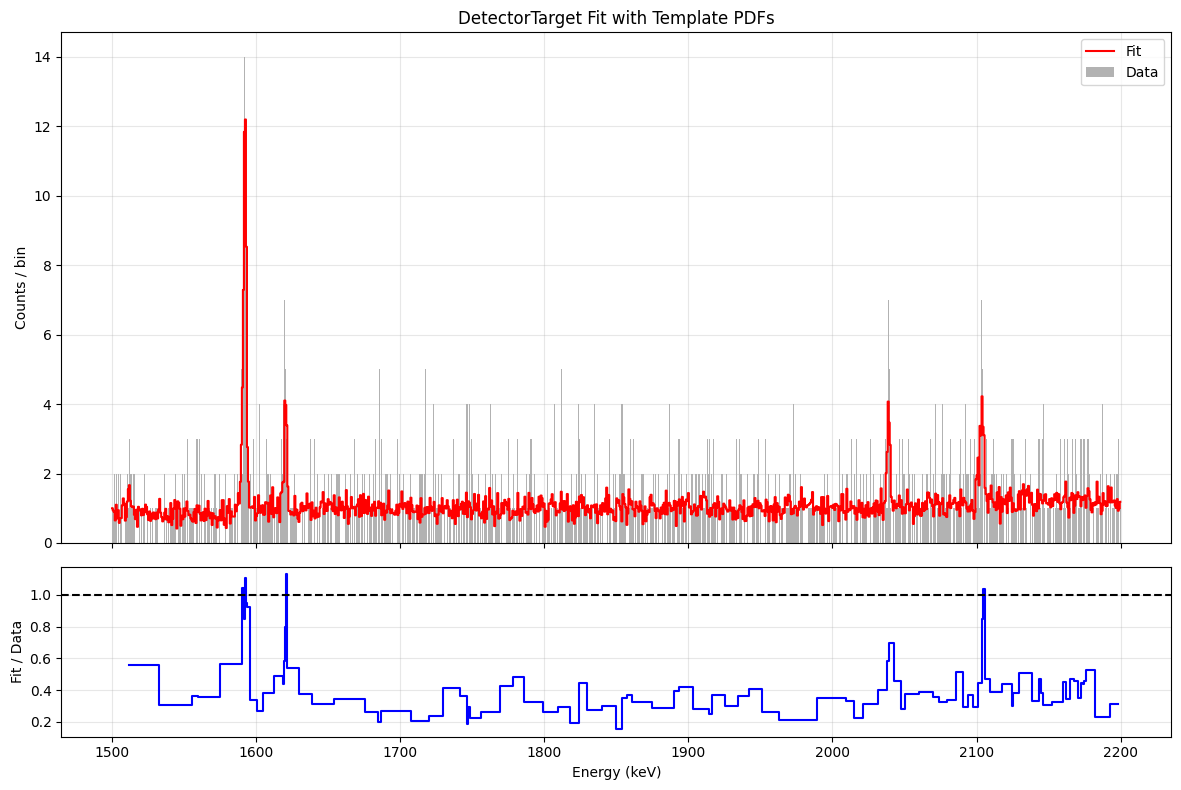

In [56]:
theta_fit, theta_error = fit_detector_target(counts_Target, pdf_A, pdf_B, pdf_C, pdf_ovbb, bin_edges)

In [45]:
### Confidence level

from iminuit import Minuit
import numpy as np
import matplotlib.pyplot as plt

def chi2_function(counts, pdf_A, pdf_B, pdf_C, pdf_ovbb):
    def chi2(theta_A, theta_B, theta_C, theta_ovbb):
        model = (theta_A * pdf_A +
                 theta_B * pdf_B +
                 theta_C * pdf_C +
                 theta_ovbb * pdf_ovbb)
        return np.sum((counts - model)**2 / (model + 1e-6))
    return chi2

def profile_ci_ovbb(counts, pdf_A, pdf_B, pdf_C, pdf_ovbb,
                    best_fit, n_scan=80, max_val=20):
    """
    Compute profile chi2 for theta_ovbb and return 90% CL.
    """
    chi2_fn = chi2_function(counts, pdf_A, pdf_B, pdf_C, pdf_ovbb)

    theta_ovbb_values = np.linspace(0, max_val, n_scan)
    chi2_profile = []

    for theta_ovbb in theta_ovbb_values:
        def chi(theta_A, theta_B, theta_C):
            return chi2_fn(theta_A, theta_B, theta_C, theta_ovbb)
        m = Minuit(chi,
                   theta_A=best_fit["theta_A"],
                   theta_B=best_fit["theta_B"],
                   theta_C=best_fit["theta_C"],
            )

        m.errordef = 1
        m.limits = [(0,None),(0,None),(0,None)]
        m.migrad()

        chi2_profile.append(m.fval)

    chi2_profile = np.array(chi2_profile)

    # best chi2
    chi2_min = np.min(chi2_profile)

    # 90% CL threshold
    delta90 = chi2_min + 2.71

    # Find CI region
    mask = chi2_profile <= delta90
    ci_low = theta_ovbb_values[mask][0]
    ci_high = theta_ovbb_values[mask][-1]

    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(theta_ovbb_values, chi2_profile, '-o', markersize=3)
    plt.axhline(chi2_min, linestyle='--', color='black', label='best fit')
    plt.axhline(delta90, linestyle='--', color='red', label='90% CL')
    plt.xlabel("theta_ovbb")
    plt.ylabel("chi2")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    print(f"90% CL interval for θ_ovbb: [{ci_low:.2f}, {ci_high:.2f}]")

    return ci_low, ci_high, theta_ovbb_values, chi2_profile


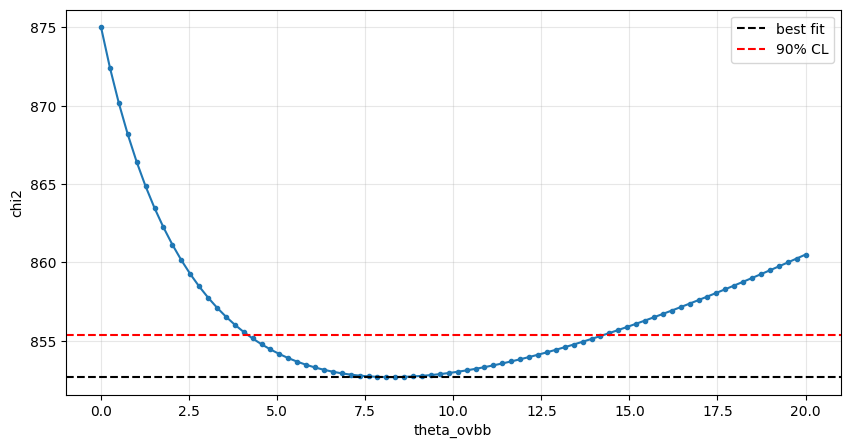

90% CL interval for θ_ovbb: [4.30, 14.18]


In [46]:
ci_low, ci_high, scan_x, scan_chi2 = profile_ci_ovbb(
    counts_Target, pdf_A, pdf_B, pdf_C, pdf_ovbb, theta_fit
)


In [47]:
from iminuit import Minuit
import numpy as np
import matplotlib.pyplot as plt

def chi2_function(counts, pdf_A, pdf_B, pdf_C, pdf_ovbb):
    """Return a chi2 function for the template fit"""
    def chi2(theta_A, theta_B, theta_C, theta_ovbb):
        model = (theta_A * pdf_A + theta_B * pdf_B + theta_C * pdf_C + theta_ovbb * pdf_ovbb)
        return np.sum((counts - model)**2 / (model + 1e-6))  # avoid div0
    return chi2

def profile_upper_limit(counts, pdf_A, pdf_B, pdf_C, pdf_ovbb,
                        best_fit, n_scan=80, max_val=20):
    """
    Profile chi2 for theta_ovbb (thetaNLDBD) and return 90% CL upper limit.
    """
    chi2_fn = chi2_function(counts, pdf_A, pdf_B, pdf_C, pdf_ovbb)
    theta_ovbb_values = np.linspace(0, max_val, n_scan)
    chi2_profile = []

    for theta_ovbb in theta_ovbb_values:
        def chi(theta_A, theta_B, theta_C):
            return chi2_fn(theta_A, theta_B, theta_C, theta_ovbb)
        m = Minuit(chi,
                   theta_A=best_fit["theta_A"],
                   theta_B=best_fit["theta_B"],
                   theta_C=best_fit["theta_C"])
        m.errordef = 1
        m.limits = [(0,None),(0,None),(0,None)]
        m.migrad()
        chi2_profile.append(m.fval)

    chi2_profile = np.array(chi2_profile)
    chi2_min = np.min(chi2_profile)
    delta90 = chi2_min + 2.71  # 90% CL for one parameter

    # Upper limit is the largest theta_ovbb below the 90% CL threshold
    mask = chi2_profile <= delta90
    upper_limit = theta_ovbb_values[mask][-1]

    return upper_limit

def compute_sensitivity(n_toys, counts_Target, pdf_A, pdf_B, pdf_C, pdf_ovbb, best_fit):
    """
    Compute the experimental sensitivity (median upper limit) using pseudo-experiments.
    """
    upper_limits = []
    total_counts = best_fit["theta_A"]*pdf_A + best_fit["theta_B"]*pdf_B + best_fit["theta_C"]*pdf_C

    for i in range(n_toys):
        # Generate pseudo-data with Poisson fluctuations under null hypothesis (theta_ovbb=0)
        toy_counts = np.random.poisson(total_counts)
        ul = profile_upper_limit(toy_counts, pdf_A, pdf_B, pdf_C, pdf_ovbb, best_fit)
        upper_limits.append(ul)

    upper_limits = np.array(upper_limits)
    median_sensitivity = np.median(upper_limits)

    # Plot
    plt.figure(figsize=(10,5))
    plt.hist(upper_limits, bins=50, alpha=0.7, color='skyblue')
    plt.axvline(median_sensitivity, color='red', linestyle='--', label='Median Sensitivity')
    plt.xlabel('θNLDBD upper limit at 90% CL')
    plt.ylabel('Number of toys')
    plt.title('Experimental Sensitivity Distribution')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    print(f"Median 90% CL upper limit (experimental sensitivity): {median_sensitivity:.2f}")

    return upper_limits, median_sensitivity


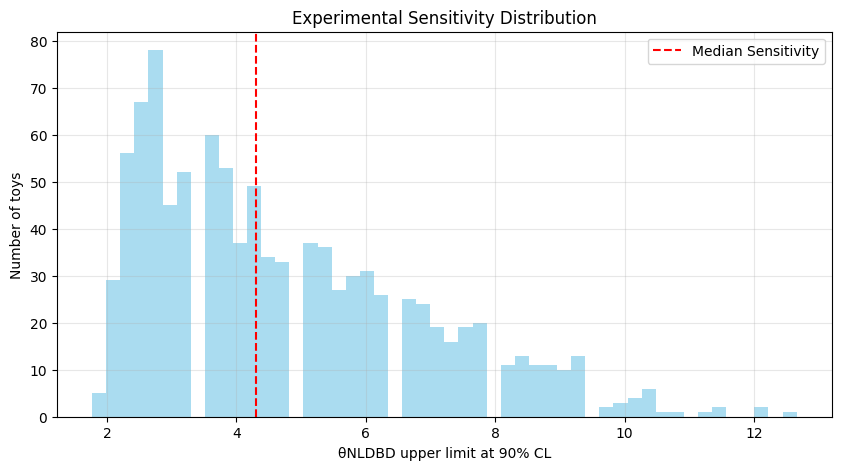

Median 90% CL upper limit (experimental sensitivity): 4.30


In [48]:
n_toys = 1000  # or 1000 for more precise result
upper_limits, median_sens = compute_sensitivity(n_toys,
                                                counts_Target,
                                                pdf_A, pdf_B, pdf_C, pdf_ovbb,
                                                theta_fit)

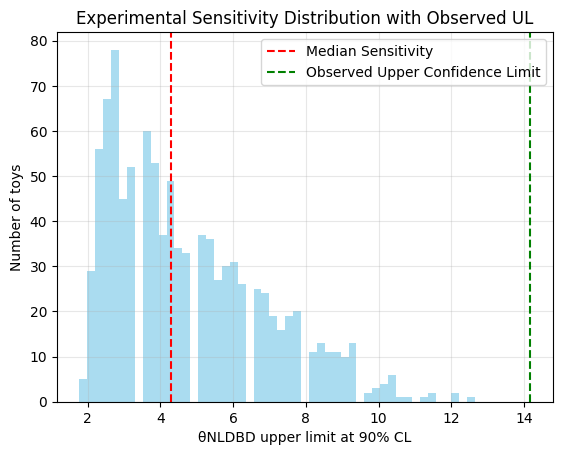

In [50]:
plt.hist(upper_limits, bins=50, alpha=0.7, color='skyblue')
plt.axvline(median_sens, color='red', linestyle='--', label='Median Sensitivity')
# plt.axvline(ci_low, color='green', linestyle='--', label='Observed Lower Confidence Limit')
plt.axvline(ci_high, color='green', linestyle='--', label='Observed Upper Confidence Limit')
plt.xlabel('θNLDBD upper limit at 90% CL')
plt.ylabel('Number of toys')
plt.title('Experimental Sensitivity Distribution with Observed UL')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
